In [1]:
# Importação das bibliotecas NLP utilizadas no projeto

In [2]:
!python3 -m spacy download pt_core_news_lg
! pip install tensorflow
from tensorflow.keras import optimizers
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.probability import FreqDist
from scipy.sparse import csr_matrix
from nltk.corpus import stopwords
from transformers import pipeline
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
%matplotlib inline
import torch
import string
import nltk
import re

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 568.2/568.2 MB 2.1 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('pt_core_news_lg')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [3]:
# Classificador para verificar se os rótulos estao relacionadas as historias de usuario
classificador = pipeline("zero-shot-classification")
rotulos = ["testador", "aplicativo", "desempenho", "teste"]

No model was supplied, defaulted to facebook/bart-large-mnli and revision c626438 (https://huggingface.co/facebook/bart-large-mnli).
Using a pipeline without specifying a model name and revision in production is not recommended.
/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public model

config.json:   0%|          | 0.00/1.15k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.63G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

In [4]:
# Reconhecimento de Entidades Relacionadas juntamente com suas classes para extrair informações importantes

roberta = pipeline("ner", grouped_entities=True, model="joelniklaus/legal-portuguese-roberta-base")

config.json:   0%|          | 0.00/699 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/443M [00:00<?, ?B/s]

Some weights of RobertaForTokenClassification were not initialized from the model checkpoint at joelniklaus/legal-portuguese-roberta-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


tokenizer_config.json:   0%|          | 0.00/403 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.41M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/167 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/pipelines/token_classification.py:168: UserWarning: `grouped_entities` is deprecated and will be removed in version v5.0.0, defaulted to `aggregation_strategy="simple"` instead.
  warnings.warn(


In [5]:
# Histórias de Usuário criadas de forma ficticia.

historias_usuario = [
    "Como um usuário,quero adicionar uma nova despesa com título, preço e categoria para acompanhar os meus gastos.",
    "Como um usuário,quero que a despesa adicionada apareça na lista de despesas imediatamente após a adição para confirmar que a despesa foi registrada com sucesso.",
    "Como um usuário,quero  modificar uma despesa existente, alterando seu título, preço ou categoria, para corrigir erros ou atualizar informações.",
    "Como um usuário,quero excluir uma despesa existente da minha lista de despesas para remover registros desnecessários ou incorretos.",
    "Como um usuário,quero adicionar a data e a hora exata da despesa para ter um registro preciso de quando os gastos ocorreram.",
    "Como um usuário,quero  visualizar uma lista de todas as minhas despesas em um único lugar para acompanhar e revisar meus gastos.",
    "Como um usuário,quero  acessar facilmente a página de adicionar despesa a partir da tela principal para registrar novos gastos rapidamente.",
    "Como um usuário,quero  confirmar a data e a hora selecionada para uma despesa antes de adicioná-la, garantindo que o registro está correto.",
    "Como um usuário,quero  adicionar múltiplas despesas com diferentes títulos, preços e categorias em uma sessão para registrar vários gastos de uma vez.",
    "Como um usuário,quero ver um resumo das minhas despesas agrupadas por categoria ou período de tempo, para entender melhor meus padrões de gastos.",
    "Como um usuário,quero  ser capaz de modificar o título, preço ou categoria de uma despesa existente,para atualizar meus dados com informações reais e atuais.",
    "Como um usuário,quero ser capaz de excluir uma despesa da lista de despesas, para ter um contreole reais das minhas despesas",
    "Como um usuário,quero ser capaz de visualizar todas as despesas adicionadas em uma lista, para atualizar meu controle de despesas",
    "Como um usuário, quero receber uma notificação de erro se eu tentar adicionar uma despesa com dados incorretos para garantir que todos os meus registros sejam válidos e completos.",
    "Como um usuário, quero poder adicionar várias despesas consecutivamente e verificar que todas foram adicionadas corretamente para garantir que nenhum registro seja perdido durante o processo de adição.",
    "Como um usuário, quero receber uma solicitação de confirmação antes de excluir uma despesa para evitar a remoção acidental de registros importantes.",
    "Como um usuário, quero editar apenas partes específicas (como título, preço ou categoria) de uma despesa sem precisar alterar outros detalhes, para facilitar a correção de erros ou atualizações.",
    "Como um usuário, quero verificar a lista de despesas após editar uma despesa para confirmar que as alterações foram aplicadas corretamente.",
    "Como um usuário, quero acessar rapidamente o resumo das minhas despesas a partir da tela principal para obter uma visão geral imediata dos meus gastos.",
    "Como um usuário, quero que todos os campos obrigatórios (como título, preço e categoria) sejam validados ao adicionar uma despesa para garantir que todos os registros estejam completos."
]


In [6]:
#sem_pontuacao = re.findall(r'\b(^[^A-Za-z])\b', historias_usuario, re.IGNORECASE)

In [7]:
# Estou utilizando os  downloads de recursos do NLTK, como tokenizadores, stopwords e lematizadores, para permitir o processamento de texto e retirar dados irrelevantes.



class ProcessadorHistoriasUsuario:
    def __init__(self):
        nltk.download('punkt')
        nltk.download('stopwords')
        nltk.download('wordnet')
        self.lemmatizer = WordNetLemmatizer()
        self.stop_words = set(stopwords.words('portuguese'))

# Função que é responsável por processar uma lista de histórias de usuário fornecidas como entrada.

    def processar_historias_usuario(self, historias_usuario):
        freq_dists = []
        for historia_usuario in historias_usuario:
            tokens = word_tokenize(historia_usuario)
            tokens = [token.lower() for token in tokens if token not in string.punctuation]
            tokens = [token for token in tokens if token not in self.stop_words]
            tokens = [self.lemmatizer.lemmatize(token) for token in tokens]
            freq_dist = FreqDist(tokens)
            freq_dists.append(freq_dist)
        return freq_dists

In [8]:
processador = ProcessadorHistoriasUsuario()
freq_dists = processador.processar_historias_usuario(historias_usuario)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


In [9]:
# Verifica a diversidade da lista processadaa de historias de usuário.

unicas = set()
for freq_dist in freq_dists:
    unicas.update(freq_dist.keys())

print("Total de palavras únicas:", len(unicas))
print("Diversidade Lexica:", len(unicas) / len(freq_dists))


Total de palavras únicas: 124
Diversidade Lexica: 6.2


In [10]:
# Um teste pra ver se fato está sendo ou nao processado, testando apenas a primeira historia, mas podendo ser escolhida qualquer outra de forma aleatoria.

historia_index = 0
print("História de usuário original:")
print(historias_usuario[historia_index])
print()
print("Apos o processamento:")
print(freq_dists[historia_index].keys())

História de usuário original:
Como um usuário,quero adicionar uma nova despesa com título, preço e categoria para acompanhar os meus gastos.

Apos o processamento:
dict_keys(['usuário', 'quero', 'adicionar', 'nova', 'despesa', 'título', 'preço', 'categoria', 'acompanhar', 'gastos'])


In [11]:
 # Verifica as distribuições de frequência de todas as histórias de usuário, e imprimindo
 # algumas informações adicionais sobre cada palavra. Isso pode ser útil para entender melhor a composição das palavras em cada
 #  história de usuário e realizar análises adicionais sobre os dados.

for i, freq_dist in enumerate(freq_dists):
    print(f"História de Usuário {i+1}:")
    for palavra, frequencia in freq_dist.most_common():
        print(f"- {palavra}:  - QTDE: ({frequencia})")
        print(f"tipo: {type(palavra)},\n Tamanho: {len(palavra)},\n Binário: {palavra.isalpha()},\n Null:{palavra == ''},\n")

História de Usuário 1:
- usuário:  - QTDE: (1)
tipo: <class 'str'>,
 Tamanho: 7,
 Binário: True,
 Null:False,

- quero:  - QTDE: (1)
tipo: <class 'str'>,
 Tamanho: 5,
 Binário: True,
 Null:False,

- adicionar:  - QTDE: (1)
tipo: <class 'str'>,
 Tamanho: 9,
 Binário: True,
 Null:False,

- nova:  - QTDE: (1)
tipo: <class 'str'>,
 Tamanho: 4,
 Binário: True,
 Null:False,

- despesa:  - QTDE: (1)
tipo: <class 'str'>,
 Tamanho: 7,
 Binário: True,
 Null:False,

- título:  - QTDE: (1)
tipo: <class 'str'>,
 Tamanho: 6,
 Binário: True,
 Null:False,

- preço:  - QTDE: (1)
tipo: <class 'str'>,
 Tamanho: 5,
 Binário: True,
 Null:False,

- categoria:  - QTDE: (1)
tipo: <class 'str'>,
 Tamanho: 9,
 Binário: True,
 Null:False,

- acompanhar:  - QTDE: (1)
tipo: <class 'str'>,
 Tamanho: 10,
 Binário: True,
 Null:False,

- gastos:  - QTDE: (1)
tipo: <class 'str'>,
 Tamanho: 6,
 Binário: True,
 Null:False,

História de Usuário 2:
- despesa:  - QTDE: (2)
tipo: <class 'str'>,
 Tamanho: 7,
 Binário: True,
 

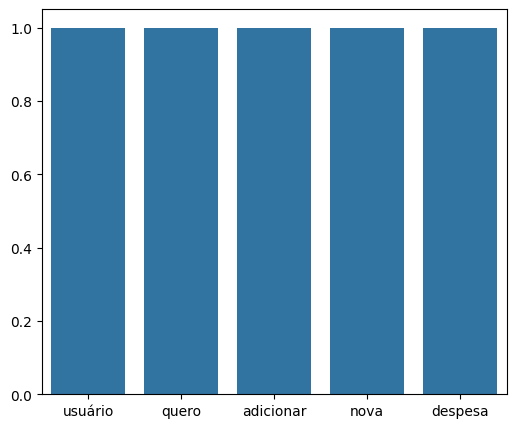

In [12]:
# Grafico para visualizar as palavras mais frequentes na primeira historia de usuario, mas poderia escolher qualquer historia aleatória

nome, valor = zip(*freq_dists[0].most_common(5))
fig, ax = plt.subplots(figsize=(6,5))
sns.barplot(x=np.array(nome), y=np.array(valor), ax=ax)
plt.show()

<Axes: >

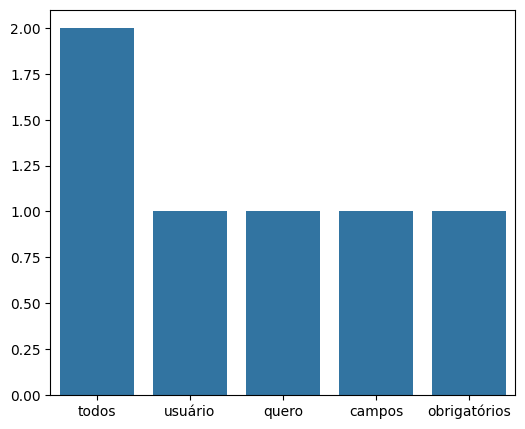

In [13]:
# Grafico para visualizar as palavras mais frequentes das historia de usuario.

nome,valor = zip(*freq_dists[i].most_common(5))
fig, ax = plt.subplots(figsize=(6,5))
sns.barplot(x=np.array(nome), y=np.array(valor), ax=ax)

In [14]:
# Imprime o rótulo previsto e a confiança associada a essa previsão para cada história.

for i, freq_dist in enumerate(freq_dists):
    historia_usuario = " ".join(freq_dist.keys())
    resultado = classificador(historia_usuario, candidate_labels=rotulos)
    top_label = resultado['labels'][0]
    confianca = resultado['scores'][0]
    print(f"História de Usuário {i+1}: Rótulo Previsto: {top_label}, Confiança: {confianca:.2f}")

História de Usuário 1: Rótulo Previsto: aplicativo, Confiança: 0.29
História de Usuário 2: Rótulo Previsto: aplicativo, Confiança: 0.44
História de Usuário 3: Rótulo Previsto: desempenho, Confiança: 0.36
História de Usuário 4: Rótulo Previsto: desempenho, Confiança: 0.36
História de Usuário 5: Rótulo Previsto: aplicativo, Confiança: 0.42
História de Usuário 6: Rótulo Previsto: aplicativo, Confiança: 0.61
História de Usuário 7: Rótulo Previsto: aplicativo, Confiança: 0.63
História de Usuário 8: Rótulo Previsto: aplicativo, Confiança: 0.33
História de Usuário 9: Rótulo Previsto: aplicativo, Confiança: 0.50
História de Usuário 10: Rótulo Previsto: desempenho, Confiança: 0.36
História de Usuário 11: Rótulo Previsto: desempenho, Confiança: 0.40
História de Usuário 12: Rótulo Previsto: aplicativo, Confiança: 0.51
História de Usuário 13: Rótulo Previsto: aplicativo, Confiança: 0.46
História de Usuário 14: Rótulo Previsto: aplicativo, Confiança: 0.48
História de Usuário 15: Rótulo Previsto: ap

In [15]:
#  Verificação que pode ser útil para entender como o modelo classifica as histórias de usuário e avaliar suas previsões.

for i, freq_dist in enumerate(freq_dists):
    historia_usuario = " ".join(freq_dist.keys())
    resultado = roberta(f"História de Usuário {i+1}: {historia_usuario}")
    print(f"Resultado para História de Usuário {i+1}:")
    for item in resultado:
        print(item)
    print()

Resultado para História de Usuário 1:
{'entity_group': 'LABEL_0', 'score': 0.6792604, 'word': ' historia de usuario 1 : usuario que', 'start': 0, 'end': 34}
{'entity_group': 'LABEL_1', 'score': 0.5217523, 'word': 'ro', 'start': 34, 'end': 36}
{'entity_group': 'LABEL_0', 'score': 0.6265085, 'word': ' adicionar nova despesa titulo preco categoria acompanhar gastos', 'start': 38, 'end': 100}

Resultado para História de Usuário 2:
{'entity_group': 'LABEL_0', 'score': 0.6804217, 'word': ' historia de usuario 2 : usuario quero despesa adicionada apareca lista despesas imediatamente apos adicao confirmar registrada sucesso', 'start': 0, 'end': 133}

Resultado para História de Usuário 3:
{'entity_group': 'LABEL_0', 'score': 0.62884563, 'word': ' historia de usuario 3 : usuario que', 'start': 0, 'end': 34}
{'entity_group': 'LABEL_1', 'score': 0.5179416, 'word': 'ro', 'start': 34, 'end': 36}
{'entity_group': 'LABEL_0', 'score': 0.56648713, 'word': ' modificar despesa existente alterando titulo p

In [16]:
# Extrai as informações de quem é o autor e finalidade das histórias de usuário

def extracao(freq_dist):
    frequencia = " ".join(freq_dist.keys()).lower()

    autor = None
    if "testador" in frequencia:
        autor = "Testador"

    finalidade = None
    for word in ["quero", "preciso", "desejo"]:
        if word in frequencia:
            pos_inicial = frequencia.find(word) + len(word)
            finalidade = frequencia[pos_inicial:].strip().split(",")[0]
            break
    if "para" in frequencia:
        pos_inicial_para = frequencia.find("para") + len("para")
        finalidade = "para " + frequencia[pos_inicial_para:].strip().split(",")[0]


    return autor, finalidade


for i, freq_dist in enumerate(freq_dists):
    autor, finalidade = extracao(freq_dist)
    print("História do Usuário:", historias_usuario[i])
    print("Autor:", autor)
    print("Finalidade:", finalidade)
    print()


História do Usuário: Como um usuário,quero adicionar uma nova despesa com título, preço e categoria para acompanhar os meus gastos.
Autor: None
Finalidade: adicionar nova despesa título preço categoria acompanhar gastos

História do Usuário: Como um usuário,quero que a despesa adicionada apareça na lista de despesas imediatamente após a adição para confirmar que a despesa foi registrada com sucesso.
Autor: None
Finalidade: despesa adicionada apareça lista despesas imediatamente após adição confirmar registrada sucesso

História do Usuário: Como um usuário,quero  modificar uma despesa existente, alterando seu título, preço ou categoria, para corrigir erros ou atualizar informações.
Autor: None
Finalidade: modificar despesa existente alterando título preço categoria corrigir erros atualizar informações

História do Usuário: Como um usuário,quero excluir uma despesa existente da minha lista de despesas para remover registros desnecessários ou incorretos.
Autor: None
Finalidade: excluir de

In [49]:
import os

data = []

for i, freq_dist in enumerate(freq_dists):
    historia_usuario = " ".join(freq_dist.keys())
    resultado = roberta(f"História de Usuário {i+1}: {historia_usuario}")
    autor, finalidade = extracao(freq_dist)

    for item in resultado:
        data.append([
            "app activity",
            "button" if "click" in item['word'] else "edittext",
            f"id/{item['word']}",
            "click" if "click" in item['word'] else "type",
            "none" if "click" in item['word'] else item['entity_group'],
            1,
            len(item['word']),
            item['word']
        ])


data = []

for i, freq_dist in enumerate(freq_dists):
    historia_usuario = " ".join(freq_dist.keys())
    resultado = roberta(f"História de Usuário {i+1}: {historia_usuario}")
    autor, finalidade = extracao(freq_dist)

    for item in resultado:
        data.append([
            "app activity",
            "button" if "click" in item['word'] else "edittext",
            f"id/{item['word']}",
            "click" if "click" in item['word'] else "type",
            "none" if "click" in item['word'] else item['entity_group'],
            1,  # Arbitrary start size
            len(item['word']),  # End size based on word length
            item['word']
        ])

# DataFrame com os dados
df = pd.DataFrame(data, columns=["activity", "field", "id", "action", "type", "size_start", "size_end", "value"])

# Cria o diretório, se não existir
output_dir = "/mnt/data"
os.makedirs(output_dir, exist_ok=True)

# Salvar o DataFrame como CSV
output_file = os.path.join(output_dir, "resultado.csv")
df.to_csv(output_file, index=False)




In [18]:
# Importa as bibliotecas utilizadas para  análises ou experimentos relacionados
# à classificação de textos usando diferentes algoritmos de aprendizado de máquina, verificanado sua performance

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import recall_score, f1_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
!pip install scikit-learn
from random import choice

In [19]:
# Vetoriza a frequencia processada de historias de usuário utilizando o TF IDF.

X = freq_dists
rotulos_possiveis = ["testador", "aplicativo", "desempenho", "teste"]
y = [choice(rotulos_possiveis) for _ in range(len(freq_dists))]
vetorizacao = TfidfVectorizer()
X = vetorizacao.fit_transform([" ".join(freq_dist.keys()) for freq_dist in X])

In [20]:
# Treina e divide dados.

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.4, random_state=42,stratify=y)

In [21]:
#Treinando o  modelo de regressão linear


modelo_regressao = LogisticRegression()
modelo_regressao.fit(X_train, y_train)
y_predicted = modelo_regressao.predict(X_test)
acuracia = accuracy_score(y_test, y_predicted)
print("Acurácia:", acuracia)

Acurácia: 0.375


In [22]:
# treinando o modelo de arvore de decisão com criterio gini e profundidade 15.

clf_tf = DecisionTreeClassifier(criterion='gini',max_depth=15)
clf_tf.fit(X_train, y_train)
pred_arvore_entropy_tf = clf_tf.predict(X_test)
accuracy_decision = accuracy_score(y_test,pred_arvore_entropy_tf)
recall = recall_score(y_test, pred_arvore_entropy_tf, average='weighted')
f1 = f1_score(y_test, pred_arvore_entropy_tf, average='weighted')
print(f"Resultado da acurácia:: ",accuracy_decision)
print(f"Resultado do Recall: ",recall)
print(f"Resultado de F1: ",f1)

Resultado da acurácia::  0.125
Resultado do Recall:  0.125
Resultado de F1:  0.08333333333333333


In [23]:
# treinando o modelo de arvore de decisão com criterio entropia e profundidade 7.

clf = DecisionTreeClassifier(criterion='entropy',max_depth=7)
clf.fit(X_train, y_train)
pred_arvore_entropy = clf.predict(X_test)
accuracy_decision = accuracy_score(y_test,pred_arvore_entropy)
recall_entropy = recall_score(y_test, pred_arvore_entropy, average='weighted')
f1_entropy = f1_score(y_test, pred_arvore_entropy, average='weighted')
print(f"Resultado da acurácia: ",accuracy_decision)
print(f"Resultado do Recall: ",recall_entropy)
print(f"Resultado de F1: ",f1_entropy)

Resultado da acurácia:  0.5
Resultado do Recall:  0.5
Resultado de F1:  0.34285714285714286


In [24]:
# treinando o modelo KNN com metrica manhattan e com tres vizinnhos proximos

clf_tf3 = KNeighborsClassifier(metric='manhattan',n_neighbors=3)
clf_tf3.fit(X_train, y_train)
pred_knn_tf = clf_tf3.predict(X_test)
acuracy_KNN = accuracy_score(y_test,pred_knn_tf)
recall_knn = recall_score(y_test, pred_knn_tf, average='weighted')
f1_knn = f1_score(y_test, pred_knn_tf, average='weighted')
print(f"Resultado da acurácia: ",acuracy_KNN)
print(f"Resultado do Recall: ",recall_knn)
print(f"Resultado de F1: ",f1_knn)

Resultado da acurácia:  0.25
Resultado do Recall:  0.25
Resultado de F1:  0.1


In [25]:
# treinando KNN com 5 vizinhos proximos , pesos 'distance' e algoritmo 'brute'

clf_tf4 = KNeighborsClassifier(n_neighbors=5,weights='distance', algorithm='brute')
clf_tf4.fit(X_train, y_train)
pred_knn_tf2 = clf_tf4.predict(X_test)
acuracy_KNN2 = accuracy_score(y_test,pred_knn_tf2)
recall_knn2 = recall_score(y_test, pred_knn_tf2, average='weighted')
f1_knn2 = f1_score(y_test, pred_knn_tf2, average='weighted')
print(f"Resultado da acurácia: ",acuracy_KNN)
print(f"Resultado do Recall: ",recall_knn2)
print(f"Resultado de F1: ",f1_knn2)

Resultado da acurácia:  0.25
Resultado do Recall:  0.5
Resultado de F1:  0.4666666666666667


In [26]:
# Treina SVM linear com parâmetro de regularização C=0.05

svc = SVC(kernel='linear', C=0.05)
svc.fit(X_train, y_train)
pred_svc = svc.predict(X_test)
accuracy_svc = accuracy_score(y_test, pred_svc)
recall_svc = recall_score(y_test, pred_svc, average='weighted')
f1_svc = f1_score(y_test, pred_svc, average='weighted')
print(f"Resultado da acurácia: ",accuracy_svc)
print(f"Resultado do Recall: ",recall_svc)
print(f"Resultado de F: ",f1_svc)


Resultado da acurácia:  0.25
Resultado do Recall:  0.25
Resultado de F:  0.1


In [27]:
# Importando as bibliotecas de Redes Neurais

from tensorflow.keras import layers
import tensorflow_datasets as tfds
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt
from tensorflow import keras
import tensorflow_hub as hub
import tensorflow as tf

In [28]:
# Codifica rótulos para treino e teste.

le_rn = LabelEncoder()
ytrain = le_rn.fit_transform(y_train)
ytest = le_rn.transform(y_test)

In [29]:
# Expandindo as dimensões conforme as entradas necessárias para o processo

Xtrain = np.expand_dims(X_train.toarray(), axis=1)
Xtest = np.expand_dims(X_test.toarray(), axis=1)

In [30]:
# Criando um modelo LSTM.

num_classes = 4
model = tf.keras.Sequential([
    layers.LSTM(128, input_shape=(Xtrain.shape[1], Xtrain.shape[2])),
    layers.Dense(64, activation='relu'),
    layers.Dense(num_classes, activation='softmax')
])

In [31]:
# Copilando o modelo LSTM

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [32]:
# Treina o modelo LSTM por 20 épocas.

EPOCHS = 20
history = model.fit(Xtrain, ytrain, epochs=EPOCHS, batch_size=32, validation_data=(Xtest, ytest))


Epoch 1/20
1/1 [==============================] - 3s 3s/step - loss: 1.3824 - accuracy: 0.2500 - val_loss: 1.3903 - val_accuracy: 0.1250
Epoch 2/20
1/1 [==============================] - 0s 67ms/step - loss: 1.3740 - accuracy: 0.5000 - val_loss: 1.3903 - val_accuracy: 0.1250
Epoch 3/20
1/1 [==============================] - 0s 40ms/step - loss: 1.3663 - accuracy: 0.9167 - val_loss: 1.3904 - val_accuracy: 0.1250
Epoch 4/20
1/1 [==============================] - 0s 58ms/step - loss: 1.3588 - accuracy: 1.0000 - val_loss: 1.3905 - val_accuracy: 0.5000
Epoch 5/20
1/1 [==============================] - 0s 39ms/step - loss: 1.3515 - accuracy: 1.0000 - val_loss: 1.3905 - val_accuracy: 0.5000
Epoch 6/20
1/1 [==============================] - 0s 49ms/step - loss: 1.3443 - accuracy: 1.0000 - val_loss: 1.3905 - val_accuracy: 0.3750
Epoch 7/20
1/1 [==============================] - 0s 50ms/step - loss: 1.3369 - accuracy: 1.0000 - val_loss: 1.3903 - val_accuracy: 0.3750
Epoch 8/20
1/1 [=============

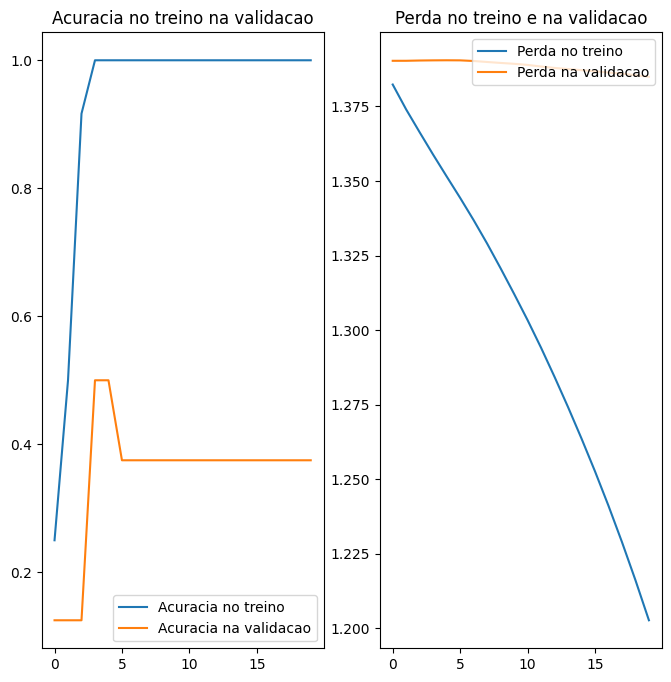

In [33]:
# Plota a acurácia e a perda durante o treinamento e a validação.

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(len(acc))

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Acuracia no treino')
plt.plot(epochs_range, val_acc, label='Acuracia na validacao')
plt.legend(loc='lower right')
plt.title('Acuracia no treino na validacao')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Perda no treino')
plt.plot(epochs_range, val_loss, label='Perda na validacao')
plt.legend(loc='upper right')
plt.title('Perda no treino e na validacao')
plt.show()


In [34]:
# Modelo LSTM utilizanado o Dropout

In [35]:
model_drop = tf.keras.Sequential([
    layers.LSTM(128, input_shape=(Xtrain.shape[1], Xtrain.shape[2])),
    layers.Dense(64, activation='relu'),
    keras.layers.Dropout(rate=0.5),
    layers.Dense(num_classes, activation='softmax')
])

In [36]:
model_drop.compile(optimizer='adam',
                   loss='sparse_categorical_crossentropy',
                   metrics=['accuracy'])

In [37]:
EPOCHS = 20
history_drop = model_drop.fit(Xtrain, ytrain, epochs=EPOCHS, batch_size=32, validation_data=(Xtest, ytest))

Epoch 1/20
1/1 [==============================] - 3s 3s/step - loss: 1.3782 - accuracy: 0.3333 - val_loss: 1.3828 - val_accuracy: 0.2500
Epoch 2/20
1/1 [==============================] - 0s 89ms/step - loss: 1.3758 - accuracy: 0.5000 - val_loss: 1.3826 - val_accuracy: 0.2500
Epoch 3/20
1/1 [==============================] - 0s 135ms/step - loss: 1.3711 - accuracy: 0.4167 - val_loss: 1.3824 - val_accuracy: 0.2500
Epoch 4/20
1/1 [==============================] - 0s 227ms/step - loss: 1.3555 - accuracy: 0.6667 - val_loss: 1.3822 - val_accuracy: 0.2500
Epoch 5/20
1/1 [==============================] - 0s 81ms/step - loss: 1.3466 - accuracy: 0.9167 - val_loss: 1.3821 - val_accuracy: 0.2500
Epoch 6/20
1/1 [==============================] - 0s 73ms/step - loss: 1.3470 - accuracy: 0.9167 - val_loss: 1.3821 - val_accuracy: 0.2500
Epoch 7/20
1/1 [==============================] - 0s 139ms/step - loss: 1.3389 - accuracy: 1.0000 - val_loss: 1.3820 - val_accuracy: 0.2500
Epoch 8/20
1/1 [==========

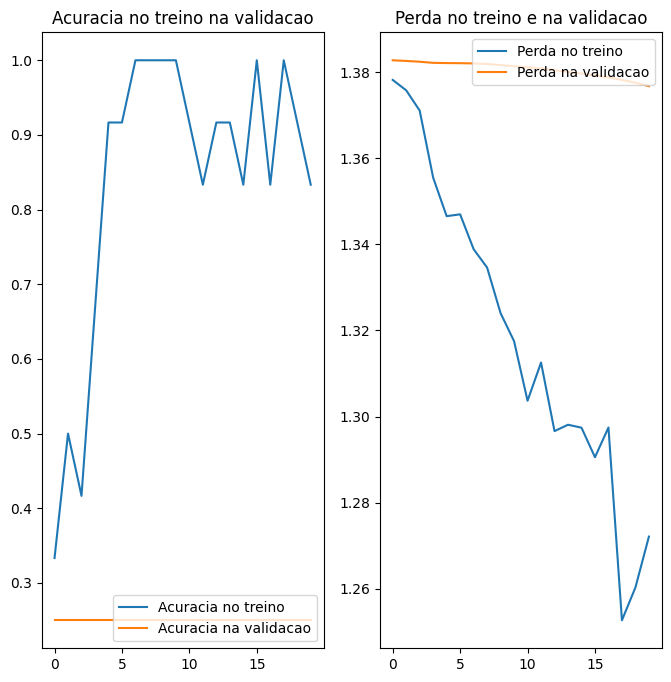

In [38]:
acc2 = history_drop.history['accuracy']
val_acc2 = history_drop.history['val_accuracy']
loss2 = history_drop.history['loss']
val_loss2 = history_drop.history['val_loss']

epochs_range = range(len(acc2))

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc2, label='Acuracia no treino')
plt.plot(epochs_range, val_acc2, label='Acuracia na validacao')
plt.legend(loc='lower right')
plt.title('Acuracia no treino na validacao')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss2, label='Perda no treino')
plt.plot(epochs_range, val_loss2, label='Perda na validacao')
plt.legend(loc='upper right')
plt.title('Perda no treino e na validacao')
plt.show()


In [39]:
# Modelo LSTM utilizanado a parada antecipada

In [40]:
model_early = tf.keras.Sequential([
    layers.LSTM(128, input_shape=(Xtrain.shape[1], Xtrain.shape[2])),
    layers.Dense(64, activation='relu'),
    layers.Dense(num_classes, activation='softmax')
])

In [41]:
model_early.compile(optimizer='adam',
                   loss='sparse_categorical_crossentropy',
                   metrics=['accuracy'])

In [42]:
callbacks = [
    keras.callbacks.EarlyStopping(
        monitor="val_loss",
        min_delta=1e-2,
        patience=5,
        restore_best_weights=True,
        verbose=1,
    )
]

In [43]:
EPOCHS = 100
history_early = model_early.fit(Xtrain, ytrain,callbacks = callbacks, epochs=EPOCHS, batch_size=32, validation_data=(Xtest, ytest))

Epoch 1/100
1/1 [==============================] - 4s 4s/step - loss: 1.3922 - accuracy: 0.1667 - val_loss: 1.3876 - val_accuracy: 0.3750
Epoch 2/100
1/1 [==============================] - 0s 76ms/step - loss: 1.3820 - accuracy: 0.4167 - val_loss: 1.3872 - val_accuracy: 0.1250
Epoch 3/100
1/1 [==============================] - 0s 77ms/step - loss: 1.3728 - accuracy: 0.6667 - val_loss: 1.3869 - val_accuracy: 0.1250
Epoch 4/100
1/1 [==============================] - 0s 83ms/step - loss: 1.3640 - accuracy: 0.9167 - val_loss: 1.3867 - val_accuracy: 0.1250
Epoch 5/100
1/1 [==============================] - 0s 127ms/step - loss: 1.3553 - accuracy: 0.9167 - val_loss: 1.3866 - val_accuracy: 0.1250
Epoch 6/100
1/1 [==============================] - 0s 138ms/step - loss: 1.3469 - accuracy: 0.9167 - val_loss: 1.3866 - val_accuracy: 0.1250
Epoch 6: early stopping


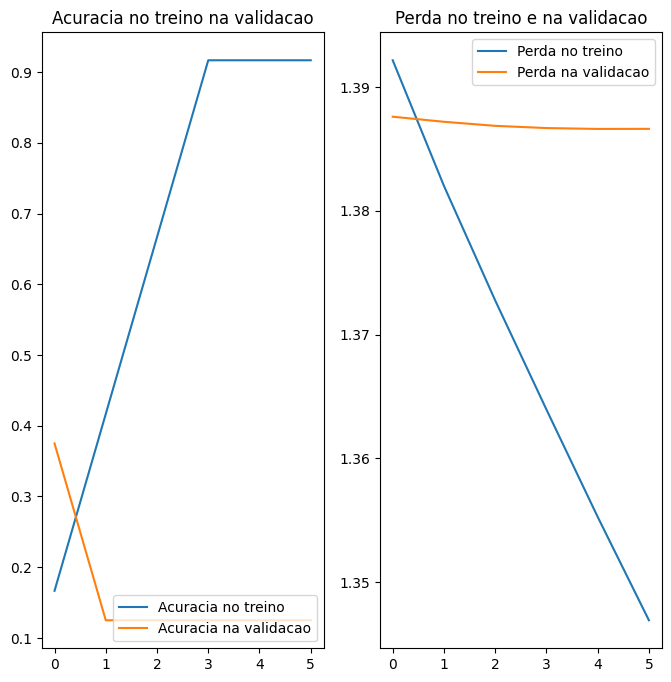

In [44]:
acc3 = history_early.history['accuracy']
val_acc3 = history_early.history['val_accuracy']
loss3 = history_early.history['loss']
val_loss3 = history_early.history['val_loss']

epochs_range = range(len(acc3))

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc3, label='Acuracia no treino')
plt.plot(epochs_range, val_acc3, label='Acuracia na validacao')
plt.legend(loc='lower right')
plt.title('Acuracia no treino na validacao')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss3, label='Perda no treino')
plt.plot(epochs_range, val_loss3, label='Perda na validacao')
plt.legend(loc='upper right')
plt.title('Perda no treino e na validacao')
plt.show()

In [50]:
from google.colab import files
files.download("historias_usuario.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>